In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../../results/variables/2024_baseline")
figures_path = Path("../../results/figures/2024_baseline")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

saving_path = Path("embeddings/2024_baseline")

In [4]:
plt.style.use("../matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [5]:
%%time
embedding_sep_all = np.load(
    berenslab_data_path / saving_path / "embedding_sep_all.npy"
)
embedding_sep_all.shape

CPU times: user 7.74 ms, sys: 29 s, total: 29 s
Wall time: 53.7 s


(23389083, 768)

# t-SNE

Annealing exgg=1, n_iter=2000 

## Affinities

In [ ]:
%%capture cap
%%time
A = affinity.Uniform(embedding_sep_all, k_neighbors=10, n_jobs=-1, verbose=1, random_state=42)

In [ ]:
with open( variables_path / 'verbose_tsne_affinities.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#save results
sp.sparse.save_npz( variables_path / "affinities_P_bert", A.P)

In [20]:
# load affinities P
affinities_P_bert_reparsed = sp.sparse.load_npz(
    variables_path / "affinities_P_bert.npz"
)

In [21]:
# create the affinities object

A = Affinities()
A.P = affinities_P_bert_reparsed

In [22]:
A.P

<23389083x23389083 sparse matrix of type '<class 'numpy.float64'>'
	with 416168180 stored elements in Compressed Sparse Row format>

## Initialization

In [23]:
%%time
%%memit

I = initialization.pca(embedding_sep_all, random_state=42)

np.save(variables_path / "initialization_bert", I)

peak memory: 149217.69 MiB, increment: 6983.41 MiB
CPU times: user 1h 3min 58s, sys: 21h 42min 26s, total: 22h 46min 24s
Wall time: 32min 29s


In [24]:
# I=np.load( variables_path / "initialization_bert.npy")

In [25]:
I

array([[ 1.0103292e-02,  1.4758382e-03],
       [ 1.0072134e-02, -2.3445622e-05],
       [ 1.0145894e-02,  1.1071160e-03],
       ...,
       [ 1.0096099e-02,  1.1193126e-03],
       [ 9.9270996e-03,  1.2011643e-03],
       [ 1.0067035e-02, -1.8473957e-03]], dtype=float32)

## Optimization

In [26]:
Zs = []
kls = []
n_iter = []


def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%time

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(
    n_iter=125,
    exaggeration=12,
    momentum=0.5,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

# exaggeration annealing
exs = np.linspace(12, 1, 125)
for i in range(125):
    if (i + 1) % 50 == 0:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
            callbacks=mycallback,
            callbacks_every_iters=1,
        )

    else:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

# final optimization without exaggeration
E = E.optimize(
    n_iter=2000,
    exaggeration=1,
    momentum=0.8,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

===> Running optimization with exaggeration=12.00, lr=1949090.25 for 125 iterations...
Iteration   50, KL divergence 13.3408, 50 iterations in 369.4615 sec
Iteration  100, KL divergence 12.7342, 50 iterations in 365.6411 sec
   --> Time elapsed: 916.84 seconds
===> Running optimization with exaggeration=12.00, lr=1949090.25 for 1 iterations...
   --> Time elapsed: 7.53 seconds
===> Running optimization with exaggeration=11.91, lr=1963606.16 for 1 iterations...
   --> Time elapsed: 7.23 seconds
===> Running optimization with exaggeration=11.82, lr=1978339.90 for 1 iterations...
   --> Time elapsed: 7.15 seconds
===> Running optimization with exaggeration=11.73, lr=1993296.42 for 1 iterations...
   --> Time elapsed: 7.63 seconds
===> Running optimization with exaggeration=11.65, lr=2008480.81 for 1 iterations...
   --> Time elapsed: 7.41 seconds
===> Running optimization with exaggeration=11.56, lr=2023898.32 for 1 iterations...
   --> Time elapsed: 7.23 seconds
===> Running optimization

In [ ]:
with open(variables_path / "verbose_tsne.txt", "w") as f:
    f.write(cap.stdout)

In [ ]:
Zs_array = []
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
# save results
f = open(variables_path / "Zs_array.pkl", "wb")
pickle.dump(Zs_array, f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "Zs_array.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [ ]:
# save iter
f = open(variables_path / "iterations_reparsed.pkl", "wb")
pickle.dump(n_iter, f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "iterations.pkl","rb")
# iterations = pickle.load(pickle_in)

In [ ]:
# save kl divergence
f = open(variables_path / "kl_divergence.pkl", "wb")
pickle.dump(kls, f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "kl_divergence.pkl","rb")
# kls = pickle.load(pickle_in)

In [ ]:
tsne=np.array(E)

#save
np.save( variables_path / "tsne_bert_sep", tsne)

In [7]:
tsne = np.load(variables_path / "tsne_bert_sep.npy")

# Plot

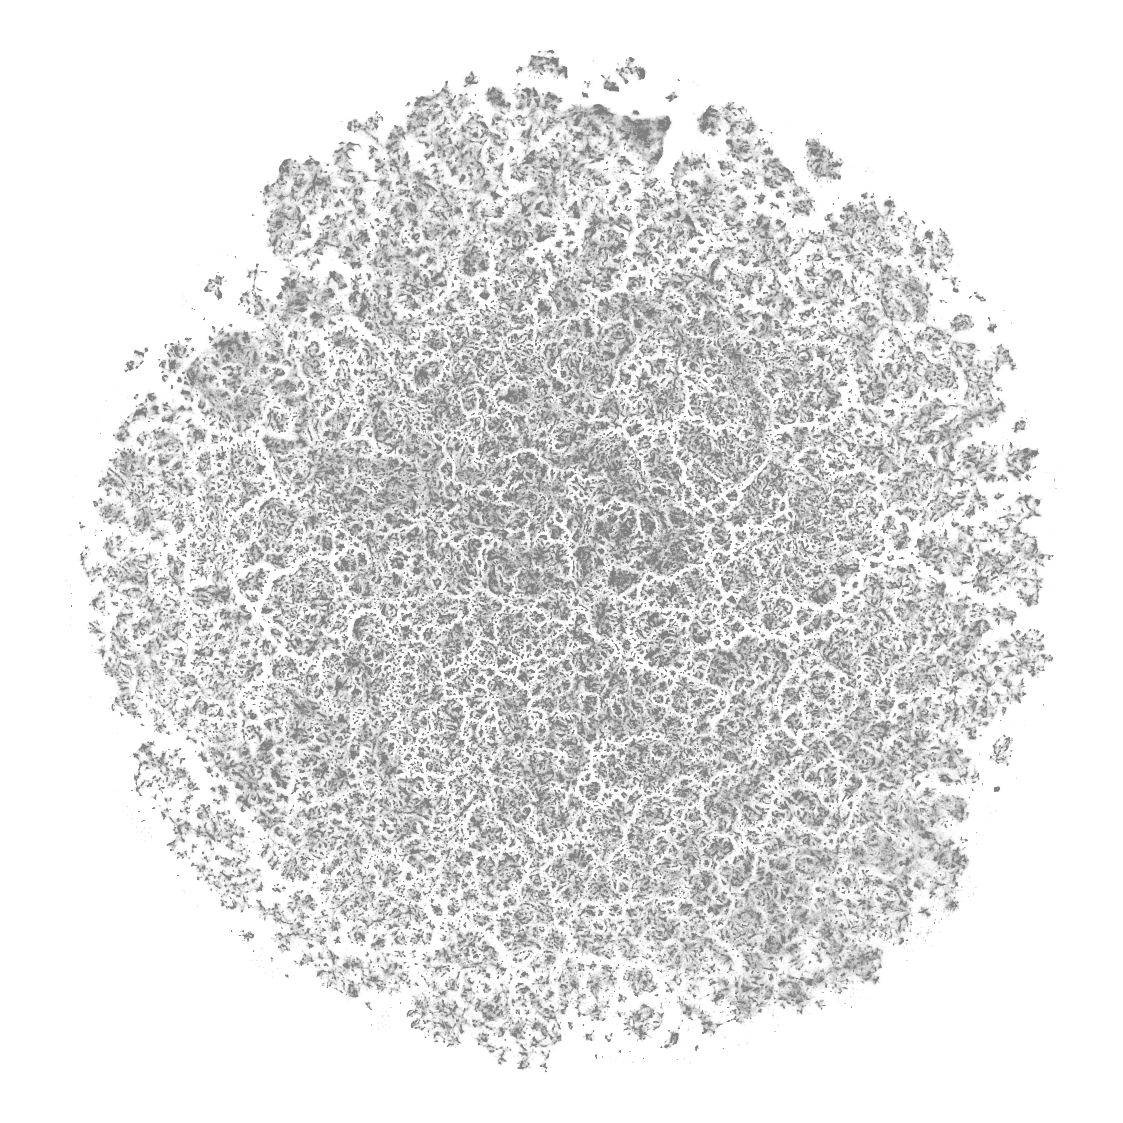

In [9]:
%matplotlib inline

tsne = tsne
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=200, layout="constrained")

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    s=0.5,
    c="grey",
    marker=".",
    linewidths=None,
    ec="None",
    alpha=0.01,
    rasterized=True,
)

# ax.grid()
ax.set_xticks([])
ax.set_yticks([])
ax.axis("equal")
ax.axis("off")

fig.savefig(figures_path / "tsne_bert_sep.png")